#### Train a single network for 3 MNIST tasks sequentially

In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from copy import deepcopy

ModuleNotFoundError: No module named 'tensorflow.examples.tutorials'

In [3]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [20]:
import tensorflow_datasets as tfds
# Construct a tf.data.Dataset
mnist = tfds.load(name="mnist")
# one hot encode for 10 MNIST classes
def my_one_hot(feature, label):
    return feature, tf.one_hot(label, depth=10)

# load your data from tfds
mnist_train, train_info = tfds.load(name="mnist", with_info=True, as_supervised=True, split=tfds.Split.TRAIN)

# convert your labels in one-hot
mnist_train = mnist_train.map(my_one_hot)

# you can batch your data here
# mnist_train = mnist_train.batch(8)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [6]:
# import class Model
from model import Model

In [7]:
# mnist imshow convenience function
# input is a 1D array of length 784
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

# return a new mnist dataset w/ pixels randomly permuted
def permute_mnist(mnist):
    perm_inds = range(mnist.train.images.shape[1])
    np.random.shuffle(perm_inds)
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2

In [8]:
# classification accuracy plotting
def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
# train/compare vanilla sgd and ewc
def train_task(model, num_iter, disp_freq, trainset, testsets, x, y_, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter/disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch = trainset.train.next_batch(100)
            model.train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][iter/disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter/disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                if l == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

In [7]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
sess =tf.compat.v1.InteractiveSession()

In [10]:
# define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [11]:
# instantiate new model
model = Model(x, y_) # simple 2-layer network

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
# initialize variables
sess.run(tf.global_variables_initializer())

In [23]:
train = [mnist_train]

#### train on task A, test on task A

In [22]:
# training 1st task
train_task(model, 800, 20, mnist_train, [mnist_train], x, y_, lams=[0])

TypeError: 'float' object cannot be interpreted as an integer

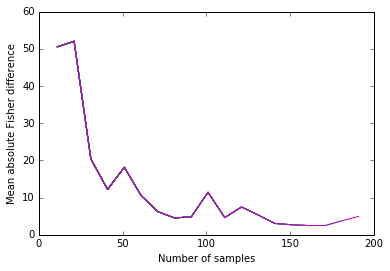

In [13]:
# Fisher information
model.compute_fisher(mnist.validation.images, sess, num_samples=200, plot_diffs=True) # use validation set for Fisher computation

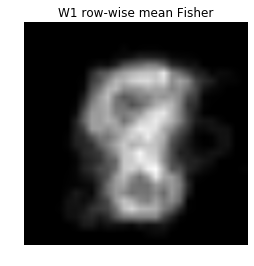

In [14]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");

#### train on task B, test on tasks A and B

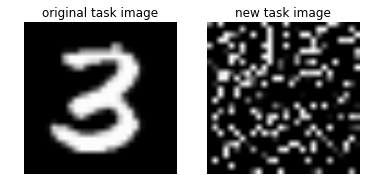

In [15]:
# permuting mnist for 2nd task
mnist2 = permute_mnist(mnist)

plt.subplot(1,2,1)
mnist_imshow(mnist.train.images[5])
plt.title("original task image")
plt.subplot(1,2,2)
mnist_imshow(mnist2.train.images[5])
plt.title("new task image");

In [16]:
# save current optimal weights
model.star()

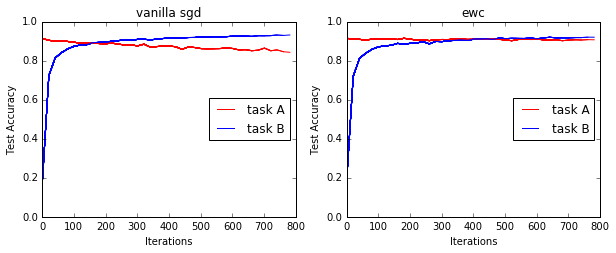

In [17]:
# training 2nd task
train_task(model, 800, 20, mnist2, [mnist, mnist2], x, y_, lams=[0, 15])

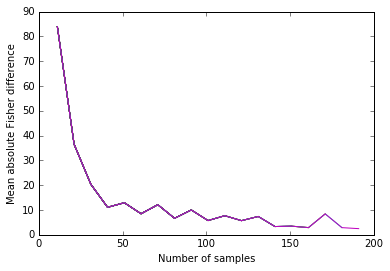

In [18]:
# Fisher information for 2nd task
model.compute_fisher(mnist2.validation.images, sess, num_samples=200, plot_diffs=True)

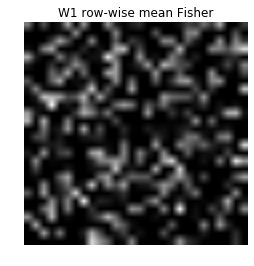

In [19]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");

#### train on task C, test on tasks A, B, and C

In [20]:
# permuting mnist for 3rd task
mnist3 = permute_mnist(mnist)

In [21]:
# save current optimal weights
model.star()

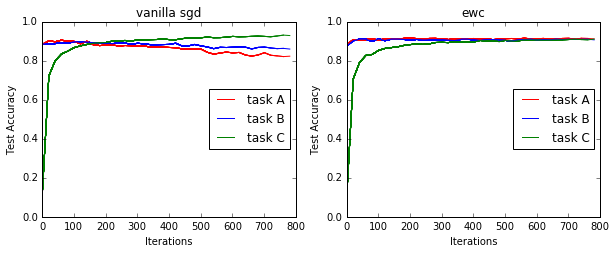

In [22]:
# training 3rd task
train_task(model, 800, 20, mnist3, [mnist, mnist2, mnist3], x, y_, lams=[0, 15])